# PREPARATION

In [387]:
# Import libraries to build a Convolutional Neural Network and work with images with TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data.experimental import AUTOTUNE, cardinality
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
import pathlib
import seaborn as sns
from collections import defaultdict
from tensorflow.keras.metrics import Recall, Accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import math

%matplotlib inline

# 1. DATA PREPROCESSING

## 1.1 Data Organization

In [388]:
# URL of the dataset
dataset_url = r"C:\Users\chris\OneDrive\Training\AI ML\UT Dallas\Projects\Project 8 - Deep Learning Incremental Capstone\prod_images"
archived_images_url = r"C:\Users\chris\OneDrive\Training\AI ML\UT Dallas\Projects\Project 8 - Deep Learning Incremental Capstone\archived_images"
# Convert the URL to a pathlib Path object
data_dir = pathlib.Path(dataset_url)
archived_data_dir = pathlib.Path(archived_images_url)
data_dir

WindowsPath('C:/Users/chris/OneDrive/Training/AI ML/UT Dallas/Projects/Project 8 - Deep Learning Incremental Capstone/prod_images')

In [389]:
# Directories of each class
bikes_dir = data_dir / 'bikes'
cars_dir = data_dir / 'cars'
archived_bikes_dir = archived_data_dir / 'bikes'
archived_cars_dir = archived_data_dir / 'cars'

In [390]:
# Folder structure of the dataset as classes and the number of images in each class
for item in data_dir.iterdir():
    if item.is_dir():
        print(f"Class: {item.name} - Number of images: {len(list(item.glob('*')))}")
    else:
        print(f"File: {item.name}")

Class: bikes - Number of images: 397
Class: cars - Number of images: 400


### The classes are well balanced

## 1.2. Exploratory Data Analysis

### Display sample images

Image: 1413738078-2649.jpg, Size: (620, 464)


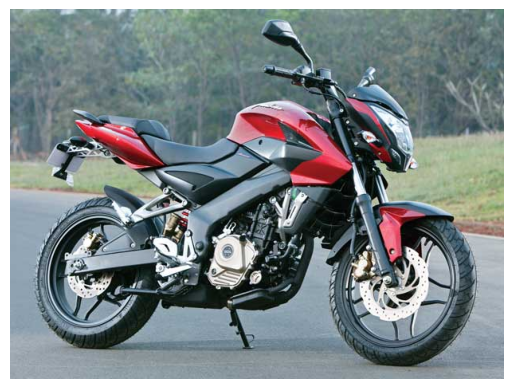

Image: 2017-Bajaj-Pulsar-150-Specifications.jpg, Size: (1024, 768)


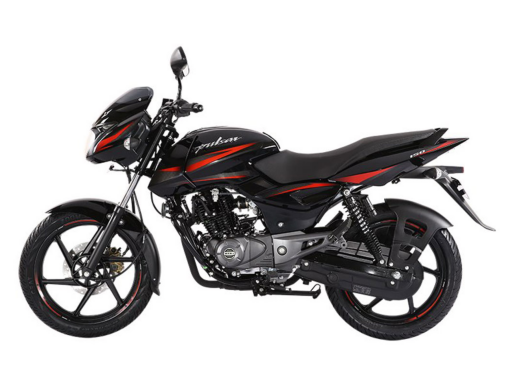

Image: 2017-Bajaj-Pulsar-NS160---25500-kms-driven-in-Gota-VB201705171774173-ak_LWBP1168733868-1584006847_gv.jpeg, Size: (262, 196)


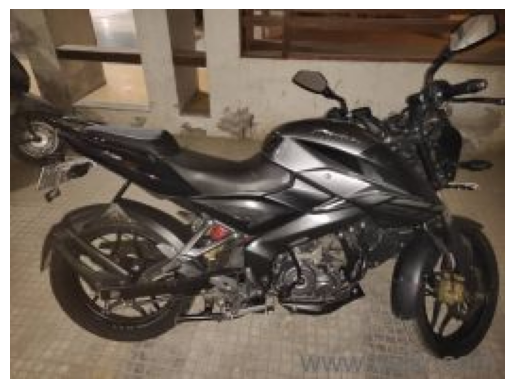

In [391]:
# Display 3 images from bikes class
bikes_images = list(bikes_dir.glob('*'))[:3]
for img_path in bikes_images:
    img = Image.open(img_path)
    # Print the image height and width
    print(f"Image: {img_path.name}, Size: {img.size}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

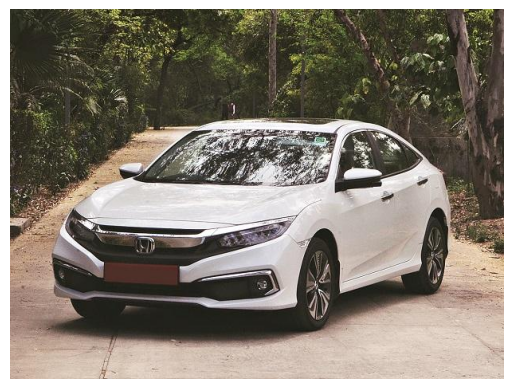

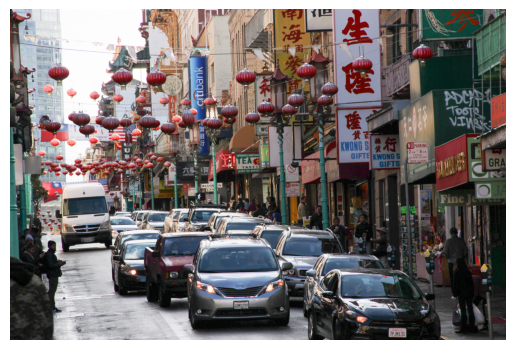

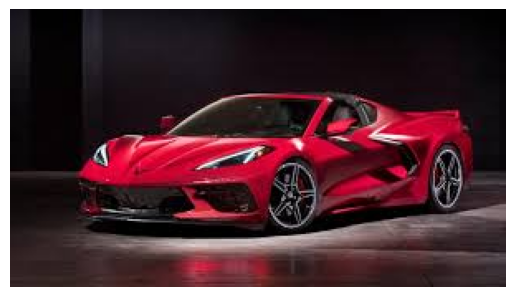

In [392]:
# Display 3 images from the cars class
cars_images = list(cars_dir.glob('*'))[:3]
for img_path in cars_images:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Analyze image dimensions 

#### Images dimensions dataframe

In [393]:
# Create a dataframe that holds the images heights, widths, labels and paths
import pandas as pd
# Create a list to hold the image data
image_data_dict = []
# Loop through each class directory
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        # Loop through each image in the class directory
        for img_path in class_dir.glob('*'):
            if img_path.is_file():
                # Open the image and get its size
                img = Image.open(img_path)
                width, height = img.size
                # Append the data to the list
                image_data_dict.append({
                    'filename': img_path.name,
                    'class': class_dir.name,
                    'width': width,
                    'height': height
                })
# Create a DataFrame from the list
image_df = pd.DataFrame(image_data_dict)
image_df


filename  class  width  height
0                                  1413738078-2649.jpg  bikes    620     464
1             2017-Bajaj-Pulsar-150-Specifications.jpg  bikes   1024     768
2    2017-Bajaj-Pulsar-NS160---25500-kms-driven-in-...  bikes    262     196
3                 45c0d9305281ef9cdaab5e5ac92b41cd.jpg  bikes    500     380
4    a340a6d064bddbdb5e4a4ba92b142a47--pre-owned-mo...  bikes    236     132
..                                                 ...    ...    ...     ...
792                                       IMG_0169.jpg   cars    997     902
793                                       IMG_0170.jpg   cars    655     544
794                                       IMG_0171.jpg   cars    773     626
795                                       IMG_0172.jpg   cars    718     615
796                           luxury-cars-in-india.png   cars    900     514

[797 rows x 4 columns]

In [394]:
bikes_df = image_df[image_df['class'] == 'bikes']
cars_df = image_df[image_df['class'] == 'cars']

In [395]:
bikes_df.describe()

width       height
count   397.000000   397.000000
mean    266.486146   210.017632
std      85.788458    81.242791
min     131.000000   117.000000
25%     242.000000   180.000000
50%     260.000000   194.000000
75%     275.000000   213.000000
max    1024.000000  1080.000000

In [396]:
cars_df.describe()

width       height
count   400.000000   400.000000
mean    283.860000   197.450000
std     126.697894    91.640753
min     168.000000   132.000000
25%     259.000000   174.000000
50%     275.000000   183.000000
75%     296.500000   194.000000
max    2400.000000  1600.000000

#### Outliers analysis function

In [397]:
# Outlier analysis using the IQR method
def analyze_outliers_iqr(df, column):
    print("Handling outliers using IQR method for column:", column, '\n')
    
    # Plot the boxplot for the column
    plt.figure(figsize=(3, 3))
    sns.boxplot(y=column, data=df)
    plt.title(column)
    plt.show()    
    
    # Calculate the IQR and bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    df_outliers_to_exclude_upper = df[df[column] > upper_bound]
    df_outliers_to_exclude_lower = df[df[column] < lower_bound]
    df_records_to_keep_not_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Print outlier statistics for lower bounds
    print(f"{column} minimum: {df[column].min()}")   
    print(f"{column} 25% quantile (Q1): {Q1}")
    print (f"{column} lower bound: {lower_bound}")
    print(f"Number of lower outliers: {len(df_outliers_to_exclude_lower)}", '\n')
    
    # Print outlier statistics for upper bounds
    print(f"{column} maximum: {df[column].max()}")
    print(f"{column} 75% quantile (Q3): {Q3}")    
    print (f"{column} upper bound: {upper_bound}")    
    print(f"Number of upper outliers: {len(df_outliers_to_exclude_upper)}", '\n')
    
    # Print total outliers and records to keep
    print(f"Number of total outliers: {len(df_outliers_to_exclude_upper) + len(df_outliers_to_exclude_lower)}", '\n')
    print(f"Number of records to keep: {len(df_records_to_keep_not_outliers)}",'\n')
    
    # Display the upper outliers
    print("Upper outliers:")
    print(df_outliers_to_exclude_upper, '\n')

    # Display the lower outliers
    print("Lower outliers:")
    print(df_outliers_to_exclude_lower, '\n')

    # Return the DataFrames for records to keep and outliers
    return {"df_records_to_keep_not_outliers": df_records_to_keep_not_outliers, "df_outliers_to_exclude_upper": df_outliers_to_exclude_upper, "df_outliers_to_exclude_lower": df_outliers_to_exclude_lower}

#### Analyze bikes height outliers

Handling outliers using IQR method for column: height 



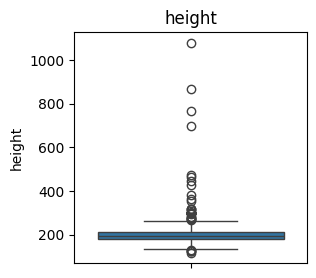

height minimum: 117
height 25% quantile (Q1): 180.0
height lower bound: 130.5
Number of lower outliers: 5 

height maximum: 1080
height 75% quantile (Q3): 213.0
height upper bound: 262.5
Number of upper outliers: 34 

Number of total outliers: 39 

Number of records to keep: 358 

Upper outliers:
                                        filename  class  width  height
0                            1413738078-2649.jpg  bikes    620     464
1       2017-Bajaj-Pulsar-150-Specifications.jpg  bikes   1024     768
3           45c0d9305281ef9cdaab5e5ac92b41cd.jpg  bikes    500     380
5                    cb-shine-125-sp-500x500.jpg  bikes    500     356
19                             download (21).jpg  bikes    172     293
68                             download (65).jpg  bikes    168     300
74                             download (70).jpg  bikes    168     300
79                             download (75).jpg  bikes    168     300
80                             download (76).jpg  bikes    164 

In [398]:
outliers_bikes_height_dict = analyze_outliers_iqr(bikes_df, 'height')

In [399]:
bikes_height_lower_outliers_df = outliers_bikes_height_dict['df_outliers_to_exclude_lower']
bikes_height_upper_outliers_df = outliers_bikes_height_dict['df_outliers_to_exclude_upper']

#### Bikes height lower outliers

In [400]:
bikes_height_lower_outliers_df

filename  class  width  height
81   download (77).jpg  bikes    272     123
144   images (133).jpg  bikes    272     128
201   images (185).jpg  bikes    262     124
208   images (191).jpg  bikes    262     124
243   images (222).jpg  bikes    238     117

bikes\download (77).jpg


<string>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\{'
<string>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\{'
C:\Users\chris\AppData\Local\Temp\ipykernel_29512\3100030219.py:3: SyntaxWarning: invalid escape sequence '\{'
  print(f"bikes\{img_filename}")


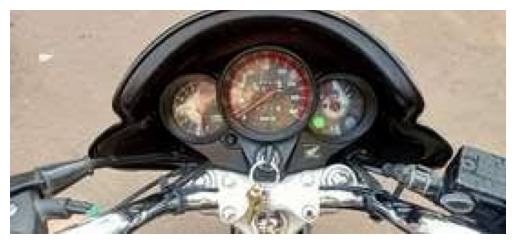

bikes\images (133).jpg


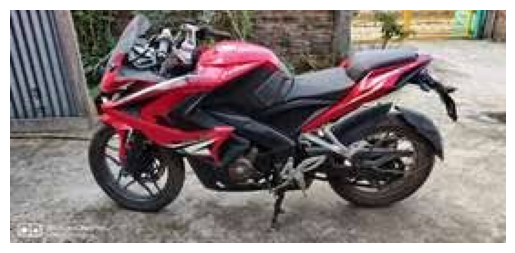

bikes\images (185).jpg


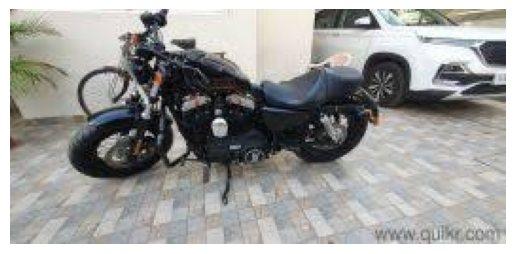

bikes\images (191).jpg


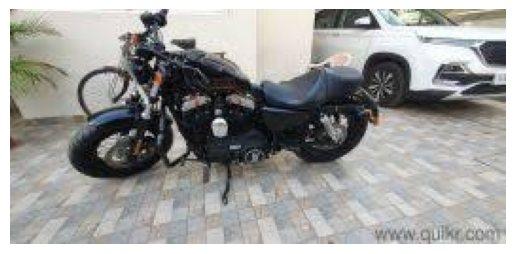

bikes\images (222).jpg


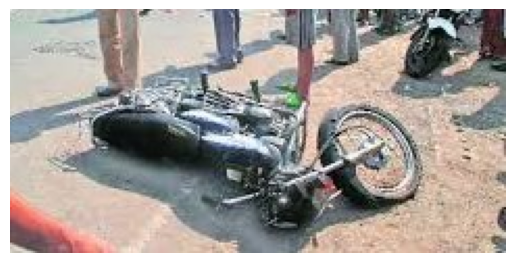

In [401]:
# Loop through bikes_height_lower_outliers_df['filename'] to display images
for img_filename in bikes_height_lower_outliers_df['filename']:
    print(f"bikes\{img_filename}")
    img_path = bikes_dir / img_filename
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#### Bikes height upper outliers

In [402]:
bikes_height_upper_outliers_df

filename  class  width  height
0                            1413738078-2649.jpg  bikes    620     464
1       2017-Bajaj-Pulsar-150-Specifications.jpg  bikes   1024     768
3           45c0d9305281ef9cdaab5e5ac92b41cd.jpg  bikes    500     380
5                    cb-shine-125-sp-500x500.jpg  bikes    500     356
19                             download (21).jpg  bikes    172     293
68                             download (65).jpg  bikes    168     300
74                             download (70).jpg  bikes    168     300
79                             download (75).jpg  bikes    168     300
80                             download (76).jpg  bikes    164     307
82                             download (78).jpg  bikes    159     318
99    e7f10fad621309c3f9bba1332c5fe525_large.jpg  bikes    320     426
101                hero-hf-deluxe-front-view.jpg  bikes    934     700
102                               Honda-Bike.jpg  bikes    430     280
103                               image (1).webp  bikes    272     363
105                                   image.webp  bikes    810    1080
189                             images (174).jpg  bikes    168     300
213                             images (196).jpg  bikes    181     279
223                             images (204).jpg  bikes    168     300
228                             images (209).jpg  bikes    168     299
233                             images (213).jpg  bikes    168     299
237                             images (217).jpg  bikes    190     265
239                             images (219).jpg  bikes    159     318
242                             images (221).jpg  bikes    168     300
308                             images (281).jpg  bikes    159     318
316                              images (32).jpg  bikes    168     300
355                       images (68) - Copy.jpg  bikes    187     269
356                              images (68).jpg  bikes    187     269
363                              images (74).jpg  bikes    187     269
373                              images (83).jpg  bikes    168     300
376                              images (86).jpg  bikes    183     275
392  ImageUploadedByTeamBHP1426390667.852791.jpg  bikes   1024     868
393                                 IMG_0173.jpg  bikes    439     446
394                             IMG_0174 (2).jpg  bikes    528     473
395                                     pic.webp  bikes    400     299

#### Loop through bikes to display images only if height is greater than 700

bikes\2017-Bajaj-Pulsar-150-Specifications.jpg


<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
C:\Users\chris\AppData\Local\Temp\ipykernel_29512\4256624845.py:7: SyntaxWarning: invalid escape sequence '\{'
  print(f"bikes\{img_filename}")


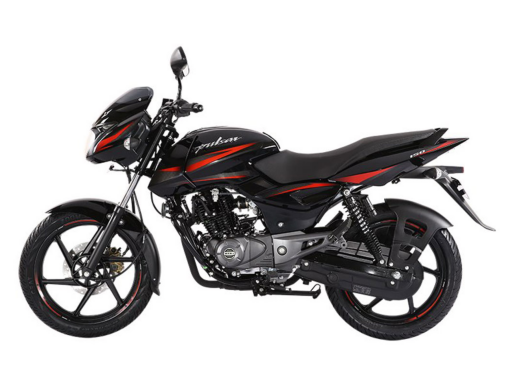

bikes\image.webp


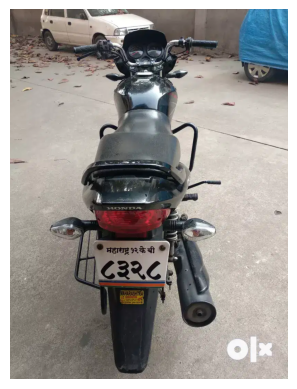

bikes\ImageUploadedByTeamBHP1426390667.852791.jpg


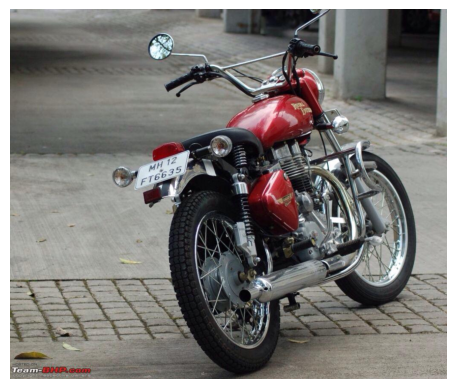

In [403]:
# Loop through bikes_height_upper_outliers_df to display images only if height is greater than 700
for i in range(len(bikes_height_upper_outliers_df)):
    img_filename = bikes_height_upper_outliers_df['filename'].iloc[i]
    img_height = bikes_height_upper_outliers_df['height'].iloc[i]
    # Only display images where height is greater than 700
    if img_height > 700:
        print(f"bikes\{img_filename}")
        img_path = bikes_dir / img_filename
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

#### The bikes heights are neither too low nor too high

#### Let's now review again the heights and widths of the bikes and cars images

In [404]:
bikes_df.describe()

width       height
count   397.000000   397.000000
mean    266.486146   210.017632
std      85.788458    81.242791
min     131.000000   117.000000
25%     242.000000   180.000000
50%     260.000000   194.000000
75%     275.000000   213.000000
max    1024.000000  1080.000000

In [405]:
cars_df.describe()

width       height
count   400.000000   400.000000
mean    283.860000   197.450000
std     126.697894    91.640753
min     168.000000   132.000000
25%     259.000000   174.000000
50%     275.000000   183.000000
75%     296.500000   194.000000
max    2400.000000  1600.000000

#### The images' dimensions are neither too low nor too high, in comparison with the heights of the bikes that we displayed above.
#### So we can proceed with the data.

### Check for corrupted or unusual images

#### Check for corrupted images

In [406]:
# Check for corrupted images in bikes and cars directories
def check_corrupted_images(directory):
    corrupted_images = []
    for img_path in directory.glob('*'):
        try:
            img = Image.open(img_path)
            img.verify()  # Verify that the image is not corrupted
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {img_path.name}")
            corrupted_images.append(img_path.name)
    return corrupted_images

corrupted_bikes = check_corrupted_images(bikes_dir)
corrupted_cars = check_corrupted_images(cars_dir)

if corrupted_bikes:
    print("Corrupted bikes images:", corrupted_bikes)
if corrupted_cars:
    print("Corrupted cars images:", corrupted_cars)

#### There are no corrupted images in the dataset

#### Check for unusual images

In [407]:
# Check for images were the ratio height/width or width/height is greater than 5
def check_size_ratio(df, height_col='height', width_col='width', ratio_threshold=5):
    outliers = df[
        (df[height_col] / df[width_col] > ratio_threshold) |
        (df[width_col] / df[height_col] > ratio_threshold)
        ]
    return outliers

outliers_bikes_size_ratio = check_size_ratio(bikes_df)
outliers_cars_size_ratio = check_size_ratio(cars_df)

if not outliers_bikes_size_ratio.empty:
    print("Bikes with size ratio outliers:")
    print(outliers_bikes_size_ratio.shape)

if not outliers_cars_size_ratio.empty:
    print("Cars with size ratio outliers:")
    print(outliers_cars_size_ratio.shape)

#### There are no unusual images (where the size ratio is greater than 5)

## 1.3 Preprocessing Pipeline

### Set parameters to generate the dataset

In [408]:
# Set parameters to generate the dataset
batch_size = 32 # must be a power of 2 for performance optimization
img_height = 180
img_width = 180
validation_split = 0.2 # must be between 0 and 1
test_split_from_validation = 0.5 # Must be between 0 and 1; Used to split the validation dataset into validation and test datasets 50/50
seed = 123 # Define seed for reproducibility
normalization_layer = layers.Rescaling(1./255) # Normalize pixel values to [0, 1]
train_data_shuffle_buffer_size = 1000 # Buffer size for shuffling the training dataset

### Functions to create the raw training, validation and test dataset

In [409]:
# Function to create the raw training dataset and temporary validation dataset
def create_raw_training_and_temp_validation_dataset(data_dir, img_height, img_width, batch_size, validation_split, seed):
    # training dataset
    train_ds = image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="training",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    
    # validation dataset
    val_ds_temp = image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    
    # Display the class names and the number of classes
    class_names = train_ds.class_names
    print("Class names:", class_names)
    print("Number of classes:", len(class_names), '\n')

    # Display the number of images in the training and validation datasets
    print("Number of training images:", len(train_ds.file_paths))
    print("Number of temporary validation images:", len(val_ds_temp.file_paths), '\n')

    # Display the number of batches in the training and validation datasets
    print("Batch size:", batch_size)
    print("Number of training batches:", cardinality(train_ds).numpy())
    print("Number of temporary validation batches:", cardinality(val_ds_temp).numpy(), '\n')
    
    return train_ds, val_ds_temp

In [410]:
# Function to count the number of images in each class
def count_images_per_class(ds, class_names):
    class_counts = defaultdict(int)
    for image, label in ds.unbatch():
        class_counts['total_images'] += 1
        class_index = int(label.numpy())  # Convert Tensor to Python int
        class_name = class_names[class_index]
        class_counts[class_name] += 1        

    return dict(class_counts)

In [411]:
# Function to create the raw validation and test dataset by splitting the temporary validation dataset
def create_raw_validation_and_test_dataset(val_ds_temp, test_split_from_validation):
    # Calculate the number of batches of the validation and test datasets
    temp_val_ds_size = cardinality(val_ds_temp).numpy()
    val_ds_size = int(temp_val_ds_size * (1 - test_split_from_validation))
    test_ds_size = temp_val_ds_size - val_ds_size

    # Shuffle the validation dataset to randomly select images for validation and testing
    val_ds = val_ds_temp.shuffle(buffer_size=temp_val_ds_size, reshuffle_each_iteration=False, seed=123)

    # Generate the new validation dataset and the test dataset
    val_ds = val_ds.take(val_ds_size)
    test_ds = val_ds_temp.skip(val_ds_size)
    
    # Display number of batches in the new validation dataset and in the test dataset
    print("Number of batches in the temporary validation dataset:", temp_val_ds_size)
    print("Number of batches in the final validation dataset:", val_ds_size)
    print("Number of batches in the test dataset:", test_ds_size, '\n')
    
    # Display the number of images per class in the new validation dataset and in the test dataset
    class_names = val_ds_temp.class_names
    print("Number of images in the temporary validation dataset:", count_images_per_class(val_ds_temp, class_names))
    print("Number of images in the final validation dataset:", count_images_per_class(val_ds, class_names))
    print("Number of images in the test dataset:", count_images_per_class(test_ds, class_names), '\n')    
    
    return val_ds, test_ds

In [412]:
# Function to create the normalized and prefetched datasets for performance optimization
def create_normalized_and_prefetched_datasets(train_ds, val_ds, test_ds, normalization_layer, train_data_shuffle_buffer_size):
    # Define AUTOTUNE for performance optimization
    AUTOTUNE = tf.data.AUTOTUNE

    # Normalize the datasets
    train_ds_nm = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    val_ds_nm = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    test_ds_nm = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

    # Prefetch the datasets for performance optimization
    train_ds_nm = train_ds_nm.cache().shuffle(train_data_shuffle_buffer_size).prefetch(buffer_size=AUTOTUNE)
    val_ds_nm = val_ds_nm.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds_nm = test_ds_nm.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds_nm, val_ds_nm, test_ds_nm

## 1.4 Create various utility functions

### Function to train the model and prepare the datasets

In [413]:
# Function to train a model and prepare the datasets
def train_model_and_prepare_datasets(
    model,
    model_name,
    data_dir,
    img_height,
    img_width,
    batch_size,
    validation_split,
    test_split_from_validation,
    seed,
    normalization_layer,
    train_data_shuffle_buffer_size,
    loss_function,
    metrics,
    epochs,
    optimizer=None,
    verbose=1
):
    # Create the raw training and temporary validation datasets
    train_ds, val_ds_temp = create_raw_training_and_temp_validation_dataset(
        data_dir, img_height, img_width, batch_size, validation_split, seed
    )

    # Create the raw validation and test datasets
    val_ds, test_ds = create_raw_validation_and_test_dataset(
        val_ds_temp, test_split_from_validation
    )

    # Create the normalized and prefetched datasets
    train_ds_nm, val_ds_nm, test_ds_nm = create_normalized_and_prefetched_datasets(
        train_ds, val_ds, test_ds, normalization_layer, train_data_shuffle_buffer_size
    )

    # Compile and train the model
    print(f"Training model: {model_name}")
    if optimizer is None:
        optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    history = model.fit(
        train_ds_nm,
        validation_data=val_ds_nm,
        epochs=epochs,
        verbose=verbose
    )

    return {
        "raw_datasets": (train_ds, val_ds, test_ds),
        "normalized_datasets": (train_ds_nm, val_ds_nm, test_ds_nm),
        "history": history
    }

### Function to plot training history

In [414]:
# Function to plot training history
def plot_training_history(history, model_name):
    history_dict = history.history
    epochs_range = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_dict['loss'], label='Training Loss')
    plt.plot(epochs_range, history_dict['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_dict['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print final results
    final_train_acc = history_dict['accuracy'][-1]
    final_val_acc = history_dict['val_accuracy'][-1]
    print(f"Final Training Accuracy: {final_train_acc:.3f}")
    print(f"Final Validation Accuracy: {final_val_acc:.3f}")

### Function to extract labels from a dataset

In [415]:
# Function to extract labels from a dataset
def get_labels_from_dataset(ds):
    labels = []
    for _, batch_labels in ds:
        labels.extend(batch_labels.numpy())
    return np.array(labels)

### Function to calculate classification model metrics

In [416]:
# Function to calculate classification model metrics
def classification_model_metrics(model, model_name, train_ds, test_ds):
    print(f"Calculating classification metrics for model: {model_name}")
    # Get labels from the training and test datasets
    y_train = get_labels_from_dataset(train_ds)
    y_test = get_labels_from_dataset(test_ds)

    # Predict probabilities for training and test datasets
    y_train_pred_prob = model.predict(train_ds).ravel()
    y_test_pred_prob = model.predict(test_ds).ravel()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Compute Youden's J statistic for each threshold
    youden_j = tpr - fpr
    optimal_threshold_index = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_threshold_index]

    # Calculate predictions for training and test sets
    y_train_pred = (y_train_pred_prob > optimal_threshold).astype("int32")
    y_test_pred = (y_test_pred_prob > optimal_threshold).astype("int32")

    # Calculate metrics
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_score_train = precision_score(y_train, y_train_pred, average='weighted')
    precision_score_test = precision_score(y_test, y_test_pred, average='weighted')
    recall_score_train = recall_score(y_train, y_train_pred, average='weighted')
    recall_score_test = recall_score(y_test, y_test_pred, average='weighted')
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_report = classification_report(y_test, y_test_pred, output_dict=True)
    
    # Plot ROC curve with the optimal threshold marked
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.4f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve\n{model_name}")
    plt.legend(loc='lower right')
    plt.show()

    # Create a DataFrame to hold the results
    classification_metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy (Train)': [accuracy_train],
        'Accuracy (Test)': [accuracy_test],
        'Precision Score (Train)': [precision_score_train],
        'Precision Score (Test)': [precision_score_test],
        'Recall Score (Train)': [recall_score_train],
        'Recall Score (Test)': [recall_score_test],
        'F1 Score (Train)': [f1_train],
        'F1 Score (Test)': [f1_test],
        'AUC': [roc_auc],
        "Youden's J": [youden_j[optimal_threshold_index]],
        "Optimal Threshold Index": [optimal_threshold_index],
        "Optimal Threshold": [optimal_threshold]
    })

    # Plot the confusion matrix with class names as labels
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['bikes', 'cars'],
                yticklabels=['bikes', 'cars'])
    plt.title(f'Confusion Matrix\n{model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Convert report to DataFrame for better visualization
    class_report_df = pd.DataFrame(class_report).transpose()
    print(class_report_df)

    # Print the metrics
    print(classification_metrics_df.T)

    return classification_metrics_df

### Function to display misclassified images

In [417]:
# Function to display misclassified images
def display_misclassified_images(model, model_name, test_ds, optimal_threshold, class_names):
    print(f"Displaying misclassified images for model: {model_name}")
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    for images, labels in test_ds:
        preds = model.predict(images)
        preds_labels = (preds > optimal_threshold).astype("int32").ravel()
        
        for i in range(len(labels)):
            if labels[i] != preds_labels[i]:
                misclassified_images.append(images[i])
                misclassified_labels.append(labels[i].numpy())
                misclassified_preds.append(preds_labels[i])

    # Print the total number of misclassified images
    total_images = len(misclassified_images)
    print(f"Total misclassified images: {total_images}")

    # Print number of misclassified images per class
    misclassified_counts = defaultdict(int)
    for label in misclassified_labels:
        class_name = class_names[label]
        misclassified_counts[class_name] += 1
    print("Number of misclassified images per class:")
    for class_name, count in misclassified_counts.items():
        print(f"{class_name}: {count}")

    # Display the misclassified images
    cols = 3
    rows = math.ceil(total_images / cols)
    
    plt.figure(figsize=(6, 2 * rows))  # Adjust size based on number of rows
    for i in range(total_images):
        true_label = class_names[misclassified_labels[i]]
        pred_label = class_names[misclassified_preds[i]]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(misclassified_images[i])
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 2. Building the CNN models

## 2.0 CNN Parameters and Data Augmentation

### Data Augmentation
#### The images will be flipped horizantaly because the cars and bikes can be left or right facing.
#### In addition, to account for the slight changes in the position and size of the bikes and cars within an image an images, the images will be:
#### 1. Slighly rotated
#### 2. Slighly translated vertically and horizontally
#### 3. Slightly zoomed in and out

In [418]:
# Data augmentation using keras.Sequential
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

### CNN Parameters

In [419]:
# CNN parameters
input_layer_shape = (img_height, img_width, 3)  # Input shape for the CNN
num_classes = 2  # Number of classes (bikes and cars)
kernel_size = (3, 3)  # Size of the convolutional filters
pool_size = (2, 2)  # Size of the pooling layers
hidden_layers_activation = 'relu'  # Activation function for hidden layers
output_layer_activation = 'sigmoid'  # Activation function for output layer
padding = 'same'  # Padding for convolutional layers

# Model parameters
loss_function = 'binary_crossentropy'  # Loss function for binary classification
metrics = ['accuracy']  # Metrics to evaluate the model

## 2.1. Baseline model WITHOUT data augmentation

In [420]:
# Baseline model WITHOUT data augmentation
baseline_model_without_augment = Sequential([
    layers.Input(shape=input_layer_shape),
    layers.Conv2D(32, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(64, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(128, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.MaxPooling2D(pool_size=pool_size),
    
    # Transition to classification
    layers.Flatten(),
    layers.Dense(128, activation=hidden_layers_activation),
    layers.Dense(1, activation=output_layer_activation)
])

## 2.2 Baseline model WITH data augmentation

In [421]:
# Baseline model WITH data augmentation
baseline_model_with_augment = Sequential([
    layers.Input(shape=input_layer_shape),
    data_augmentation,
    layers.Conv2D(32, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(64, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(128, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.MaxPooling2D(pool_size=pool_size),
    
    # Transition to classification
    layers.Flatten(),
    layers.Dense(128, activation=hidden_layers_activation),
    layers.Dense(1, activation=output_layer_activation)
])

## 2.3 Advanced model with max and avg pooling

In [422]:
# Build and advanced model with different pooling strategies
advanced_model_max_and_avg_pool = Sequential([
    layers.Input(shape=input_layer_shape),
    data_augmentation,
    layers.Conv2D(32, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(64, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.BatchNormalization(),
    layers.AveragePooling2D(pool_size=pool_size),
    layers.Conv2D(128, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(256, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.BatchNormalization(),
    layers.AveragePooling2D(pool_size=pool_size),
    
    # Transition to classification
    layers.Flatten(),    
    layers.Dense(256, activation=hidden_layers_activation),    
    layers.BatchNormalization(),    
    layers.Dropout(0.2),
    layers.Dense(128, activation=hidden_layers_activation),    
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation=output_layer_activation)
])

## 2.4 Advanced model with max pooling only

In [423]:
# Build and advanced model with max pooling only
advanced_model_max_pool_only = Sequential([
    layers.Input(shape=input_layer_shape),
    data_augmentation,
    layers.Conv2D(32, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(64, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(128, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(256, kernel_size, activation=hidden_layers_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=pool_size),
    
    # Transition to classification
    layers.Flatten(),
    layers.Dense(256, activation=hidden_layers_activation),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation=hidden_layers_activation),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation=output_layer_activation)
])  

# 3. Models Training

In [424]:
# Number of epochs
epochs = 10

## 3.1 Model Training #1 - Base line model WITHOUT data augmentation

### Training the baseline model WITHOUT data augmentation

In [425]:
# Train the baseline model WITHOUT data augmentation
train_results_1 = train_model_and_prepare_datasets(
    baseline_model_without_augment,
    "Baseline Model Without Data Augmentation",
    data_dir,
    img_height,
    img_width,
    batch_size,
    validation_split,
    test_split_from_validation,
    seed,
    normalization_layer,
    train_data_shuffle_buffer_size,
    loss_function,
    metrics,
    epochs,
    optimizer=keras.optimizers.Adam(),
    verbose=1
)
# Capture the results
train_ds_1, val_ds_1, test_ds_1 = train_results_1["raw_datasets"]
train_ds_nm_1, val_ds_nm_1, test_ds_nm_1 = train_results_1["normalized_datasets"]
history_1 = train_results_1["history"]

Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
Class names: ['bikes', 'cars']
Number of classes: 2 

Number of training images: 633
Number of temporary validation images: 158 

Batch size: 32
Number of training batches: 20
Number of temporary validation batches: 5 

Number of batches in the temporary validation dataset: 5
Number of batches in the final validation dataset: 2
Number of batches in the test dataset: 3 

Number of images in the temporary validation dataset: {'total_images': 158, 'bikes': 83, 'cars': 75}
Number of images in the final validation dataset: {'total_images': 64, 'cars': 25, 'bikes': 39}
Number of images in the test dataset: {'total_images': 94, 'cars': 38, 'bikes': 56} 

Training model: Baseline Model Without Data Augmentation
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.5357 - loss: 1.0887 - val_accuracy: 0.8594 - val_loss: 0.4595
Epoch 2/10
20/20 

### Visualize the training history of the baseline model WITHOUT data augmentation

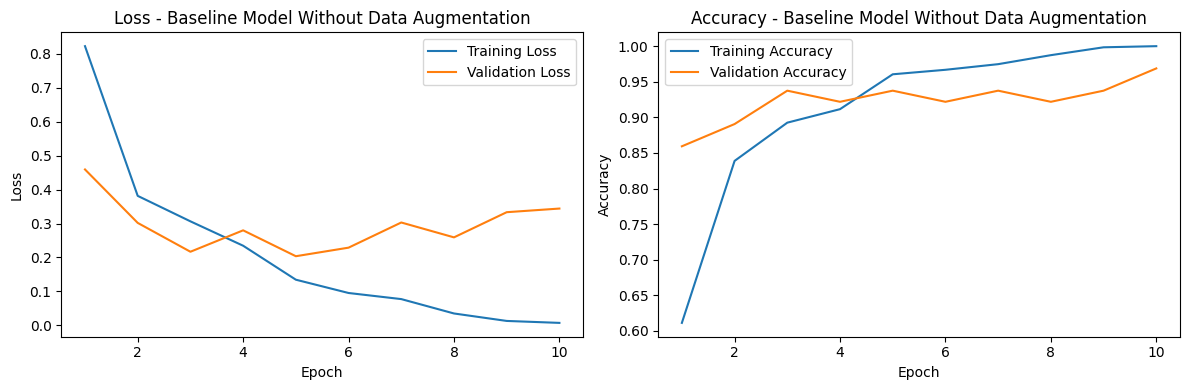

Final Training Accuracy: 1.000
Final Validation Accuracy: 0.969


In [426]:
# Plot the training history for the baseline model without data augmentation
plot_training_history(history_1, "Baseline Model Without Data Augmentation")

## 3.2 Model Training #2 - Baseline model WITH data augmentation

### Training the baseline model WITH data augmentation

In [427]:
# Train the baseline model with data augmentation
train_results_2 = train_model_and_prepare_datasets(
    baseline_model_with_augment,
    "Baseline Model With Data Augmentation",
    data_dir,
    img_height,
    img_width,
    batch_size,
    validation_split,
    test_split_from_validation,
    seed,
    normalization_layer,
    train_data_shuffle_buffer_size,
    loss_function,
    metrics,
    epochs,
    optimizer=keras.optimizers.Adam(),
    verbose=1
)
# Capture the results
train_ds_2, val_ds_2, test_ds_2 = train_results_2["raw_datasets"]
train_ds_nm_2, val_ds_nm_2, test_ds_nm_2 = train_results_2["normalized_datasets"]
history_2 = train_results_2["history"]

Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
Class names: ['bikes', 'cars']
Number of classes: 2 

Number of training images: 633
Number of temporary validation images: 158 

Batch size: 32
Number of training batches: 20
Number of temporary validation batches: 5 

Number of batches in the temporary validation dataset: 5
Number of batches in the final validation dataset: 2
Number of batches in the test dataset: 3 

Number of images in the temporary validation dataset: {'total_images': 158, 'bikes': 83, 'cars': 75}
Number of images in the final validation dataset: {'total_images': 64, 'cars': 25, 'bikes': 39}
Number of images in the test dataset: {'total_images': 94, 'cars': 38, 'bikes': 56} 

Training model: Baseline Model With Data Augmentation
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.5153 - loss: 0.8032 - val_accuracy: 0.6406 - val_loss: 0.6406
Epoch 2/10
20/20 ━━━

### Visualize the training history of the baseline model WITH data augmentation

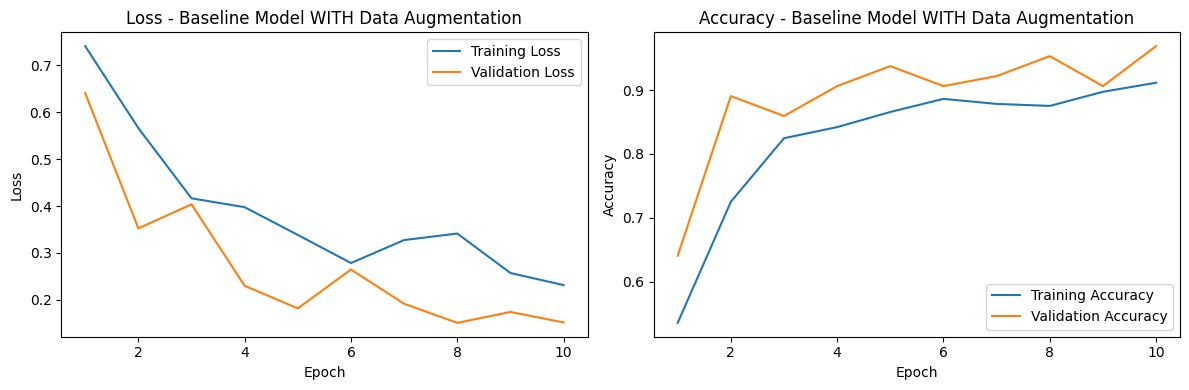

Final Training Accuracy: 0.912
Final Validation Accuracy: 0.969


In [428]:
# Plot the training history of the baseline model with data augmentation
plot_training_history(history_2, "Baseline Model WITH Data Augmentation")

## 3.3 Model Training #3 - Advanced model with max and avg pooling

### Train the advanced model with max and average pooling

In [429]:
# Train the advanced model with max and average pooling
train_results_3 = train_model_and_prepare_datasets(
    advanced_model_max_and_avg_pool,
    "Advanced Model with Max and Average Pooling",
    data_dir,
    img_height,
    img_width,
    batch_size,
    validation_split,
    test_split_from_validation,
    seed,
    normalization_layer,
    train_data_shuffle_buffer_size,
    loss_function,
    metrics,
    epochs,
    optimizer=keras.optimizers.Adam(),
    verbose=1
)
# Capture the results
train_ds_3, val_ds_3, test_ds_3 = train_results_3["raw_datasets"]
train_ds_nm_3, val_ds_nm_3, test_ds_nm_3 = train_results_3["normalized_datasets"]
history_3 = train_results_3["history"]

Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
Class names: ['bikes', 'cars']
Number of classes: 2 

Number of training images: 633
Number of temporary validation images: 158 

Batch size: 32
Number of training batches: 20
Number of temporary validation batches: 5 

Number of batches in the temporary validation dataset: 5
Number of batches in the final validation dataset: 2
Number of batches in the test dataset: 3 

Number of images in the temporary validation dataset: {'total_images': 158, 'bikes': 83, 'cars': 75}
Number of images in the final validation dataset: {'total_images': 64, 'cars': 25, 'bikes': 39}
Number of images in the test dataset: {'total_images': 94, 'cars': 38, 'bikes': 56} 

Training model: Advanced Model with Max and Average Pooling
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 594ms/step - accuracy: 0.7130 - loss: 0.6890 - val_accuracy: 0.6406 - val_loss: 0.6478
Epoch 2/10
20

### Visualize the training history of the advanced model with max and average pooling

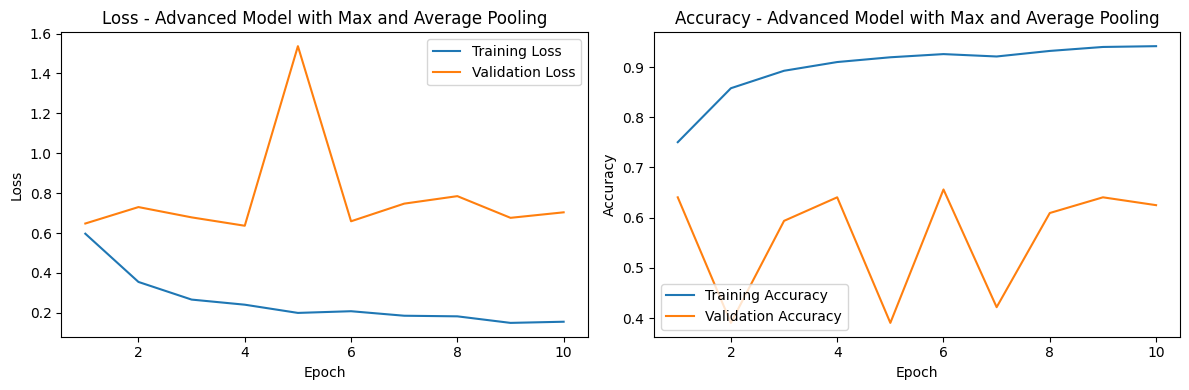

Final Training Accuracy: 0.942
Final Validation Accuracy: 0.625


In [430]:
# Plot the training history for the advanced model with max pooling only
plot_training_history(history_3, "Advanced Model with Max and Average Pooling")

## 3.4 Model Training #4 - Advanced model with max pooling only

### Train the advanced model with max pooling only

In [431]:
# Train the advanced model with max pooling only
train_results_4 = train_model_and_prepare_datasets(
    advanced_model_max_pool_only,
    "Advanced Model with Max Pooling Only",
    data_dir,
    img_height,
    img_width,
    batch_size,
    validation_split,
    test_split_from_validation,
    seed,
    normalization_layer,
    train_data_shuffle_buffer_size,
    loss_function,
    metrics,
    epochs,
    optimizer=keras.optimizers.Adam(),
    verbose=1
)
# Capture the results
train_ds_4, val_ds_4, test_ds_4 = train_results_4["raw_datasets"]
train_ds_nm_4, val_ds_nm_4, test_ds_nm_4 = train_results_4["normalized_datasets"]
history_4 = train_results_4["history"]

Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
Class names: ['bikes', 'cars']
Number of classes: 2 

Number of training images: 633
Number of temporary validation images: 158 

Batch size: 32
Number of training batches: 20
Number of temporary validation batches: 5 

Number of batches in the temporary validation dataset: 5
Number of batches in the final validation dataset: 2
Number of batches in the test dataset: 3 

Number of images in the temporary validation dataset: {'total_images': 158, 'bikes': 83, 'cars': 75}
Number of images in the final validation dataset: {'total_images': 64, 'cars': 25, 'bikes': 39}
Number of images in the test dataset: {'total_images': 94, 'cars': 38, 'bikes': 56} 

Training model: Advanced Model with Max Pooling Only
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 534ms/step - accuracy: 0.7034 - loss: 0.6768 - val_accuracy: 0.3438 - val_loss: 0.8440
Epoch 2/10
20/20 ━━━

### Visualize the training history of the advanced model with max and average pooling

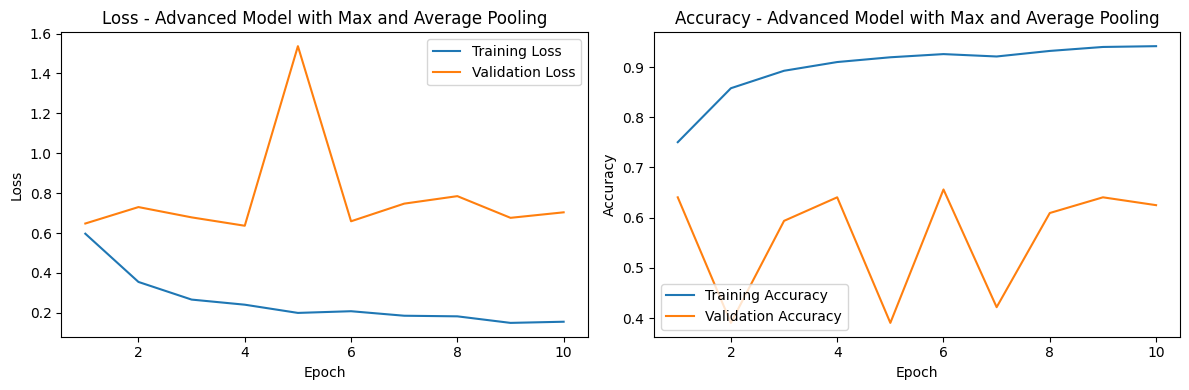

Final Training Accuracy: 0.942
Final Validation Accuracy: 0.625


In [432]:
# Plot the training history for the advanced model with max pooling only
plot_training_history(history_3, "Advanced Model with Max and Average Pooling")

# 4. Model Evaluation

## 4.1 Evaluate the baseline model without data augmentation

### Metrics of the baseline model without data augmentation


Evaluating the baseline model without data augmentation on the test dataset...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9276 - loss: 0.5319
Test Loss with default probability threshold (0.5): 0.535
Test Accuracy with default probability threshold (0.5): 0.926
Calculating classification metrics for model: Baseline Model Without Data Augmentation
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


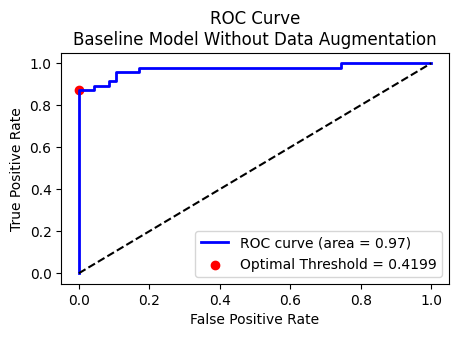

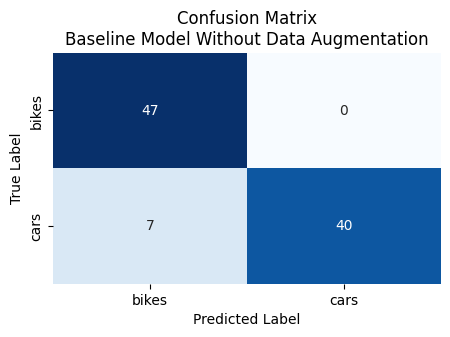

              precision    recall  f1-score    support
0              0.870370  1.000000  0.930693  47.000000
1              1.000000  0.851064  0.919540  47.000000
accuracy       0.925532  0.925532  0.925532   0.925532
macro avg      0.935185  0.925532  0.925117  94.000000
weighted avg   0.935185  0.925532  0.925117  94.000000
                                                                0
Model                    Baseline Model Without Data Augmentation
Accuracy (Train)                                         0.510269
Accuracy (Test)                                          0.925532
Precision Score (Train)                                  0.510269
Precision Score (Test)                                   0.935185
Recall Score (Train)                                     0.510269
Recall Score (Test)                                      0.925532
F1 Score (Train)                                         0.510269
F1 Score (Test)                                          0.925117
AUC       

In [433]:
# Calculate test accuracy and loss for the baseline model without data augmentation
print("\nEvaluating the baseline model without data augmentation on the test dataset...")
test_loss_1, test_accuracy_1 = baseline_model_without_augment.evaluate(test_ds_nm_1)
print(f"Test Loss with default probability threshold (0.5): {test_loss_1:.3f}")
print(f"Test Accuracy with default probability threshold (0.5): {test_accuracy_1:.3f}")

# Generate the classification metrics for the baseline model without data augmentation
classification_metrics_df_1 = classification_model_metrics(
    baseline_model_without_augment, "Baseline Model Without Data Augmentation",
    train_ds_nm_1, test_ds_nm_1)

classification_metrics_df_all_results = classification_metrics_df_1.copy()

### Misclassified images for the baseline model without data augmentation

Displaying misclassified images for model: Baseline Model Without Data Augmentation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Total misclassified images: 7
Number of misclassified images per class:
cars: 7


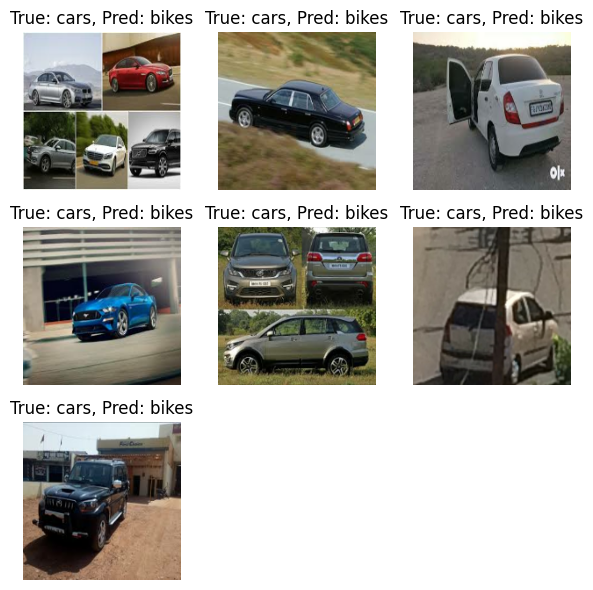

In [434]:
display_misclassified_images(
    baseline_model_without_augment,
    "Baseline Model Without Data Augmentation",
    test_ds_nm_1,
    classification_metrics_df_1['Optimal Threshold'].values[0],
    train_ds_1.class_names
    )

## 4.2 Evaluate the baseline model with data augmentation

### Metrics of the baseline model with data augmentation


Evaluating the baseline model with data augmentation on the test dataset...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9343 - loss: 0.2675
Test Loss with default probability threshold (0.5): 0.227
Test Accuracy with default probability threshold (0.5): 0.947
Calculating classification metrics for model: Baseline Model With Data Augmentation
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


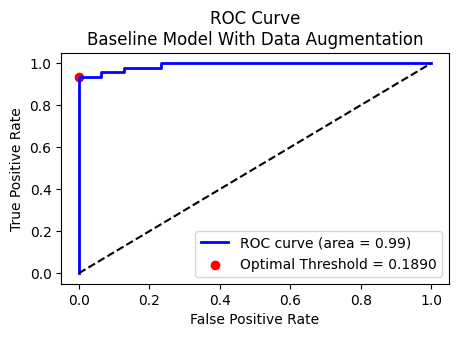

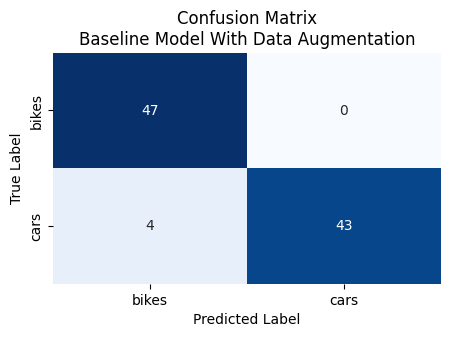

              precision    recall  f1-score    support
0              0.921569  1.000000  0.959184  47.000000
1              1.000000  0.914894  0.955556  47.000000
accuracy       0.957447  0.957447  0.957447   0.957447
macro avg      0.960784  0.957447  0.957370  94.000000
weighted avg   0.960784  0.957447  0.957370  94.000000
                                                             0
Model                    Baseline Model With Data Augmentation
Accuracy (Train)                                      0.508689
Accuracy (Test)                                       0.957447
Precision Score (Train)                               0.509696
Precision Score (Test)                                0.960784
Recall Score (Train)                                  0.508689
Recall Score (Test)                                   0.957447
F1 Score (Train)                                       0.50852
F1 Score (Test)                                        0.95737
AUC                                     

Model  Accuracy (Train)  \
0  Baseline Model Without Data Augmentation          0.510269   
1     Baseline Model With Data Augmentation          0.508689   

   Accuracy (Test)  Precision Score (Train)  Precision Score (Test)  \
0         0.925532                 0.510269                0.935185   
1         0.957447                 0.509696                0.960784   

   Recall Score (Train)  Recall Score (Test)  F1 Score (Train)  \
0              0.510269             0.925532          0.510269   
1              0.508689             0.957447          0.508520   

   F1 Score (Test)       AUC  Youden's J  Optimal Threshold Index  \
0         0.925117  0.973291     0.87234                        3   
1         0.957370  0.990946     0.93617                        2   

   Optimal Threshold  
0           0.419860  
1           0.189035

In [435]:
# Calculate test accuracy and loss for the baseline model with data augmentation
print("\nEvaluating the baseline model with data augmentation on the test dataset...")
test_loss_2, test_accuracy_2 = baseline_model_with_augment.evaluate(test_ds_nm_2)
print(f"Test Loss with default probability threshold (0.5): {test_loss_2:.3f}")
print(f"Test Accuracy with default probability threshold (0.5): {test_accuracy_2:.3f}")

# Generate the classification metrics for the baseline model with data augmentation
classification_metrics_df_2 = classification_model_metrics(
    baseline_model_with_augment, "Baseline Model With Data Augmentation",
    train_ds_nm_2, test_ds_nm_2)
classification_metrics_df_all_results = pd.concat([classification_metrics_df_all_results, classification_metrics_df_2], ignore_index=True)
classification_metrics_df_all_results

### Misclassified images for the baseline model with data augmentation

Displaying misclassified images for model: Baseline Model With Data Augmentation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Total misclassified images: 4
Number of misclassified images per class:
cars: 4


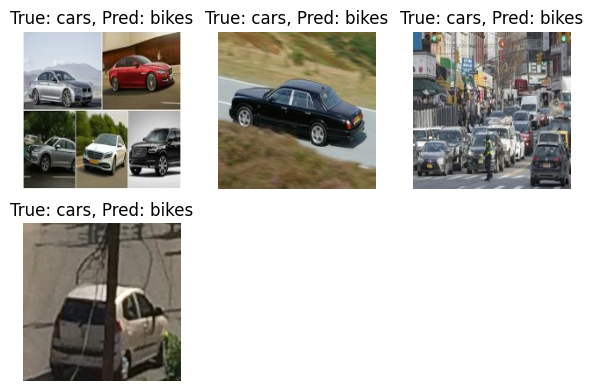

In [436]:
# Display misclassified images for the baseline model with data augmentation
display_misclassified_images(
    baseline_model_with_augment,
    "Baseline Model With Data Augmentation",
    test_ds_nm_2,
    classification_metrics_df_2['Optimal Threshold'].values[0],
    train_ds_2.class_names
)

## 4.3 Evaluate the advanced model with max and average pooling

### Metrics for the advanced model with max and average pooling


Evaluating the advanced model with max and average pooling on the test dataset...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5760 - loss: 0.7534
Test Loss with default probability threshold (0.5): 0.815
Test Accuracy with default probability threshold (0.5): 0.543
Calculating classification metrics for model: Advanced Model with Max and Average Pooling
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


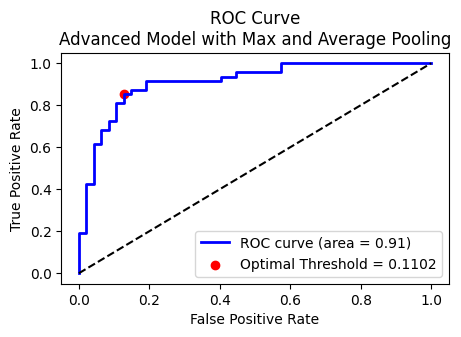

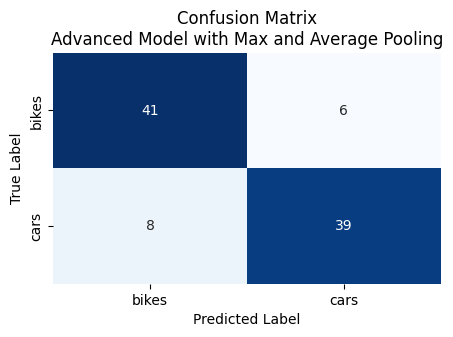

              precision    recall  f1-score    support
0              0.836735  0.872340  0.854167  47.000000
1              0.866667  0.829787  0.847826  47.000000
accuracy       0.851064  0.851064  0.851064   0.851064
macro avg      0.851701  0.851064  0.850996  94.000000
weighted avg   0.851701  0.851064  0.850996  94.000000
                                                                   0
Model                    Advanced Model with Max and Average Pooling
Accuracy (Train)                                            0.488152
Accuracy (Test)                                             0.851064
Precision Score (Train)                                     0.487886
Precision Score (Test)                                      0.851701
Recall Score (Train)                                        0.488152
Recall Score (Test)                                         0.851064
F1 Score (Train)                                            0.487975
F1 Score (Test)                                  

Model  Accuracy (Train)  \
0     Baseline Model Without Data Augmentation          0.510269   
1        Baseline Model With Data Augmentation          0.508689   
2  Advanced Model with Max and Average Pooling          0.488152   

   Accuracy (Test)  Precision Score (Train)  Precision Score (Test)  \
0         0.925532                 0.510269                0.935185   
1         0.957447                 0.509696                0.960784   
2         0.851064                 0.487886                0.851701   

   Recall Score (Train)  Recall Score (Test)  F1 Score (Train)  \
0              0.510269             0.925532          0.510269   
1              0.508689             0.957447          0.508520   
2              0.488152             0.851064          0.487975   

   F1 Score (Test)       AUC  Youden's J  Optimal Threshold Index  \
0         0.925117  0.973291    0.872340                        3   
1         0.957370  0.990946    0.936170                        2   
2         0.850996  0.910819    0.723404                       14   

   Optimal Threshold  
0           0.419860  
1           0.189035  
2           0.110218

In [437]:
# Calculate test accuracy and loss for the advanced model with max and average pooling
print("\nEvaluating the advanced model with max and average pooling on the test dataset...")
test_loss_3, test_accuracy_3 = advanced_model_max_and_avg_pool.evaluate(test_ds_nm_3)
print(f"Test Loss with default probability threshold (0.5): {test_loss_3:.3f}")
print(f"Test Accuracy with default probability threshold (0.5): {test_accuracy_3:.3f}")

# Generate the classification metrics for the advanced model with max and average pooling
classification_metrics_df_3 = classification_model_metrics(
    advanced_model_max_and_avg_pool, "Advanced Model with Max and Average Pooling",
    train_ds_nm_3, test_ds_nm_3)
classification_metrics_df_all_results = pd.concat([classification_metrics_df_all_results, classification_metrics_df_3], ignore_index=True)
classification_metrics_df_all_results

### Misclassified images for the advanced model with max and average pooling

Displaying misclassified images for model: Advanced Model with Max and Average Pooling
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Total misclassified images: 14
Number of misclassified images per class:
cars: 8
bikes: 6


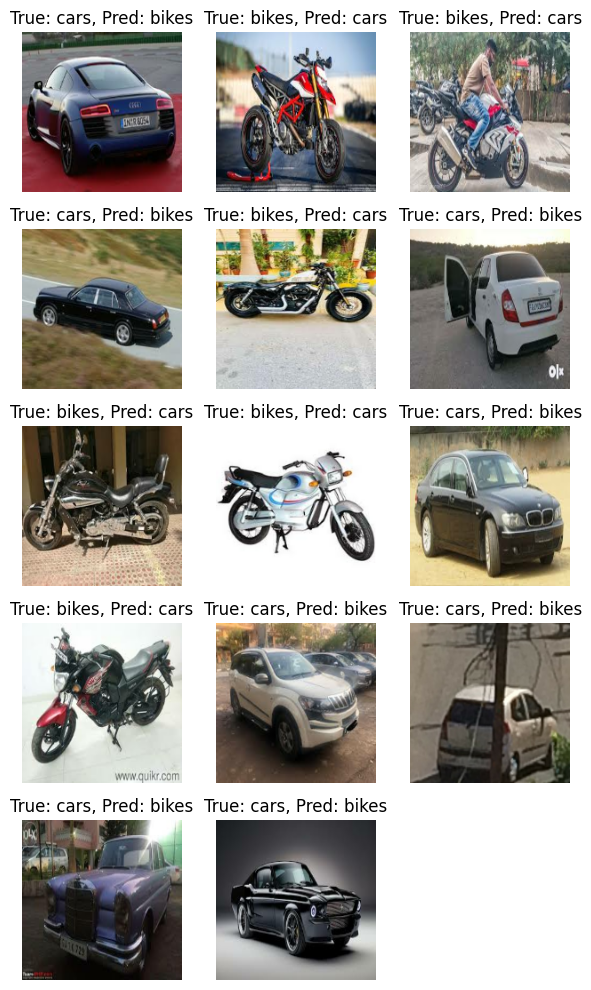

In [438]:
# Display misclassified images for the advanced model with max and average pooling
display_misclassified_images(
    advanced_model_max_and_avg_pool,
    "Advanced Model with Max and Average Pooling",
    test_ds_nm_3,
    classification_metrics_df_3['Optimal Threshold'].values[0],
    train_ds_3.class_names
)

## 4.4 Evaluate the advanced model with max pooling only

### Metrics for the advanced model with max pooling only


Evaluating the advanced model with max pooling only on the test dataset...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4688 - loss: 1.5506
Test Loss with default probability threshold (0.5): 1.476
Test Accuracy with default probability threshold (0.5): 0.500
Calculating classification metrics for model: Advanced Model with Max Pooling Only
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


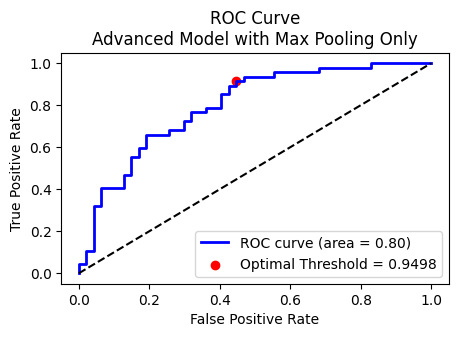

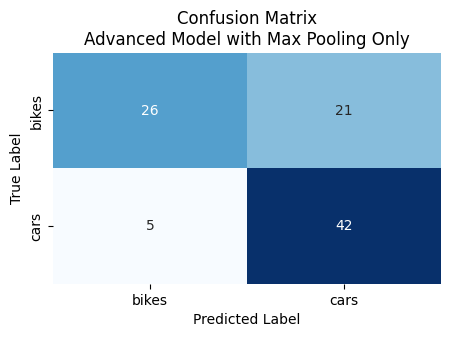

              precision    recall  f1-score    support
0              0.838710  0.553191  0.666667  47.000000
1              0.666667  0.893617  0.763636  47.000000
accuracy       0.723404  0.723404  0.723404   0.723404
macro avg      0.752688  0.723404  0.715152  94.000000
weighted avg   0.752688  0.723404  0.715152  94.000000
                                                            0
Model                    Advanced Model with Max Pooling Only
Accuracy (Train)                                     0.567141
Accuracy (Test)                                      0.723404
Precision Score (Train)                              0.568162
Precision Score (Test)                               0.752688
Recall Score (Train)                                 0.567141
Recall Score (Test)                                  0.723404
F1 Score (Train)                                     0.559712
F1 Score (Test)                                      0.715152
AUC                                               

Model  Accuracy (Train)  \
0     Baseline Model Without Data Augmentation          0.510269   
1        Baseline Model With Data Augmentation          0.508689   
2  Advanced Model with Max and Average Pooling          0.488152   
3         Advanced Model with Max Pooling Only          0.567141   

   Accuracy (Test)  Precision Score (Train)  Precision Score (Test)  \
0         0.925532                 0.510269                0.935185   
1         0.957447                 0.509696                0.960784   
2         0.851064                 0.487886                0.851701   
3         0.723404                 0.568162                0.752688   

   Recall Score (Train)  Recall Score (Test)  F1 Score (Train)  \
0              0.510269             0.925532          0.510269   
1              0.508689             0.957447          0.508520   
2              0.488152             0.851064          0.487975   
3              0.567141             0.723404          0.559712   

   F1 Score (Test)       AUC  Youden's J  Optimal Threshold Index  \
0         0.925117  0.973291    0.872340                        3   
1         0.957370  0.990946    0.936170                        2   
2         0.850996  0.910819    0.723404                       14   
3         0.715152  0.797193    0.468085                       30   

   Optimal Threshold  
0           0.419860  
1           0.189035  
2           0.110218  
3           0.949808

In [439]:
# Calculate test accuracy and loss for the advanced model with max pooling only
print("\nEvaluating the advanced model with max pooling only on the test dataset...")
test_loss_4, test_accuracy_4 = advanced_model_max_pool_only.evaluate(test_ds_nm_4)
print(f"Test Loss with default probability threshold (0.5): {test_loss_4:.3f}")
print(f"Test Accuracy with default probability threshold (0.5): {test_accuracy_4:.3f}")

# Generate the classification metrics for the advanced model with max pooling only
classification_metrics_df_4 = classification_model_metrics(
    advanced_model_max_pool_only, "Advanced Model with Max Pooling Only",
    train_ds_nm_4, test_ds_nm_4)
classification_metrics_df_all_results = pd.concat([classification_metrics_df_all_results, classification_metrics_df_4], ignore_index=True)
classification_metrics_df_all_results

### Misclassified images for the advanced model with max pooling only

Displaying misclassified images for model: Advanced Model with Max Pooling Only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Total misclassified images: 26
Number of misclassified images per class:
bikes: 21
cars: 5


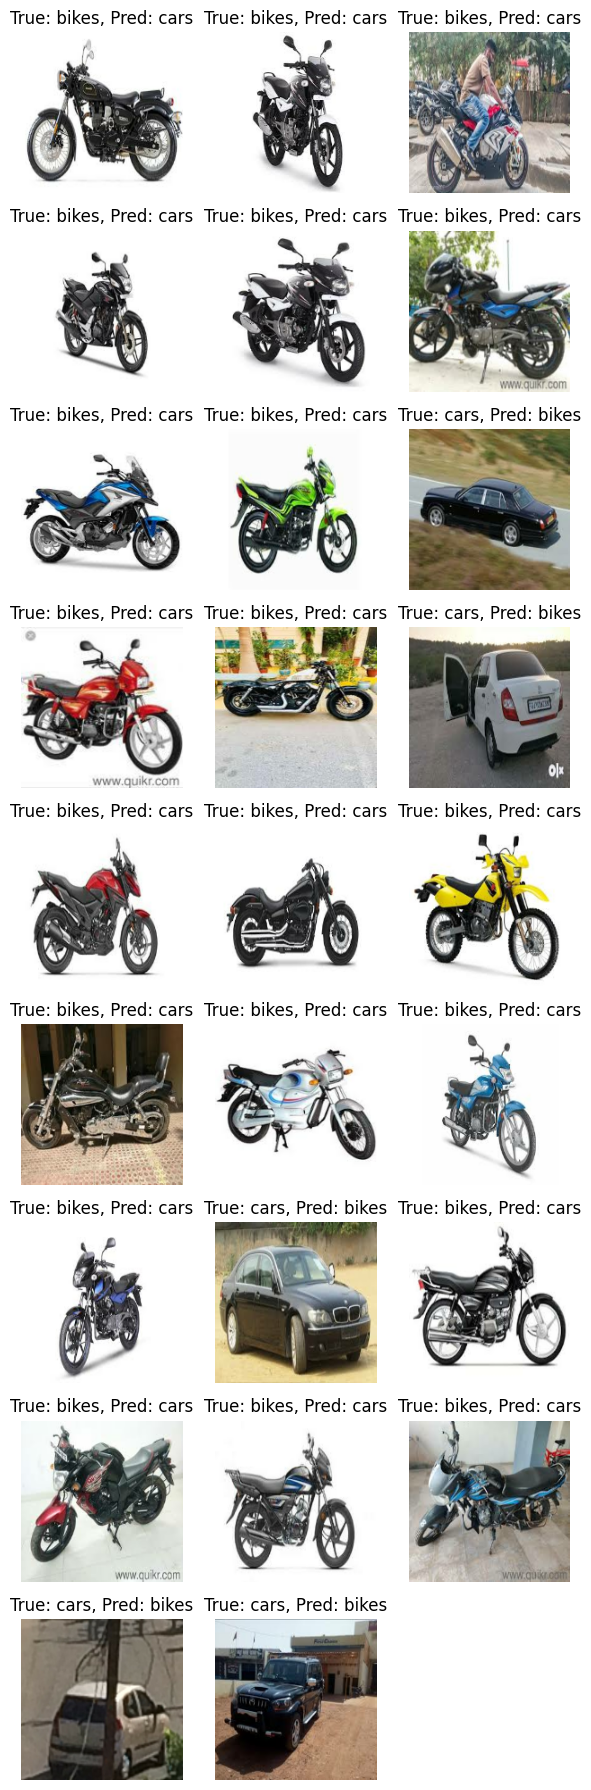

In [440]:
# Display misclassified images for the advanced model with max pooling only
display_misclassified_images(
    advanced_model_max_pool_only,
    "Advanced Model with Max Pooling Only",
    test_ds_nm_4,
    classification_metrics_df_4['Optimal Threshold'].values[0],
    train_ds_4.class_names
)

# 5. CONCLUSION

In [441]:
classification_metrics_df_all_results

Model  Accuracy (Train)  \
0     Baseline Model Without Data Augmentation          0.510269   
1        Baseline Model With Data Augmentation          0.508689   
2  Advanced Model with Max and Average Pooling          0.488152   
3         Advanced Model with Max Pooling Only          0.567141   

   Accuracy (Test)  Precision Score (Train)  Precision Score (Test)  \
0         0.925532                 0.510269                0.935185   
1         0.957447                 0.509696                0.960784   
2         0.851064                 0.487886                0.851701   
3         0.723404                 0.568162                0.752688   

   Recall Score (Train)  Recall Score (Test)  F1 Score (Train)  \
0              0.510269             0.925532          0.510269   
1              0.508689             0.957447          0.508520   
2              0.488152             0.851064          0.487975   
3              0.567141             0.723404          0.559712   

   F1 Score (Test)       AUC  Youden's J  Optimal Threshold Index  \
0         0.925117  0.973291    0.872340                        3   
1         0.957370  0.990946    0.936170                        2   
2         0.850996  0.910819    0.723404                       14   
3         0.715152  0.797193    0.468085                       30   

   Optimal Threshold  
0           0.419860  
1           0.189035  
2           0.110218  
3           0.949808

#### Total number of images in the original dataset: 797
#### Number of images in the training dataset: 633
#### Number of images in the validation dataset: 39
#### Number of images in the test dataset: 56
#### Number of models tested: 4
#### Epochs = 10
#### Description of the models tested:
#### 1. Baseline Model Without Data Augmentation: A simple CNN model without data augmentation
#### 2. Baseline Model With Data Augmentation: A simple CNN model with data augmentation
#### 3. Advanced Model with Max and Average Pooling: A more complex CNN model with both max and average pooling layers
#### 4. Advanced Model with Max Pooling Only: A more complex CNN model with only max pooling layers

#### Results Summary:
#### The baseline model with data augmentation performed better all models:
#### 1. Best test accuracy: 0.957
#### 2. Best AUC: 0.99

#### The advances models perform poorly compared to the baseline models, surprisingly.
#### The class that posed the most challenge for the models was the 'bikes' class, which had more misclassified images than the 'cars' class accross all models...
#### ... But for the selected model, the challenging class was only the car class: only 4 images misclassified...
#### The missclasified car images present the following patterns:
#### 1. The car is obstructed by a pole
#### 2. There are multiple car images in the same picture, which may confuse the model
#### 3. The image shows a street with multiple cars in traffic, which may confuse the model
#### 4. The car is in the middle of green landscape which a dark green color that is close to car color

#### Problem with the models
#### The test metrics are consistently better than the training metrics, which may indicate a problem with the models. It requires further investigation

Displaying misclassified images for model: Baseline Model With Data Augmentation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Total misclassified images: 4
Number of misclassified images per class:
cars: 4


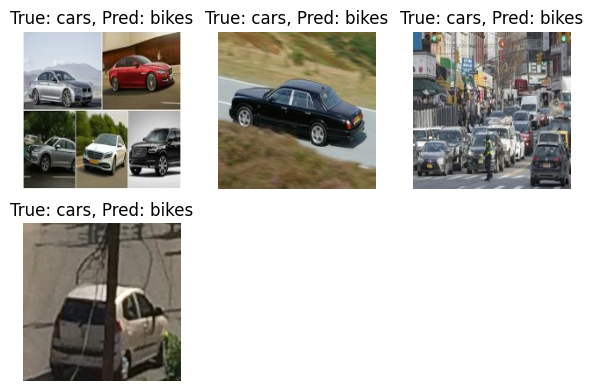

In [443]:
display_misclassified_images(
    baseline_model_with_augment,
    "Baseline Model With Data Augmentation",
    test_ds_nm_2,
    classification_metrics_df_2['Optimal Threshold'].values[0],
    train_ds_2.class_names
)